This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N^2}\right)
$$

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [24]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20830234100>)

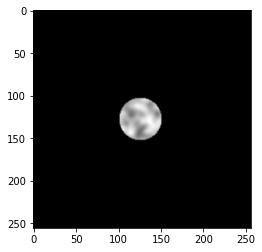

In [25]:
# Potentially add noise to the image
sigma = 0.05
im1_noised = im1 + sigma * np.random.randn(np.shape(im1)[0],np.shape(im1)[1])
plt.figure(),plt.imshow(im1_noised,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [26]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref)
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want to do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2083054de80>)

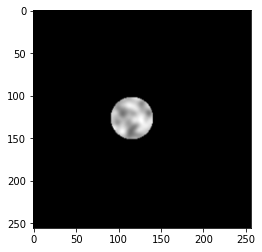

In [27]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

In [35]:
im2_noised = applyAffineMotion(im1_noised,b)
IM1_noised =  np.fft.fft2(im1_noised)
IM2_noised =  np.fft.fft2(im2_noised)

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

In [28]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [29]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [36]:
phi_noised = angle2D(IM2_noised/IM1_noised)

In [30]:
phi = angle2D(IM2/IM1)
phi

array([[ 5.        ,  4.9609375 ,  4.921875  , ..., -4.8828125 ,
        -4.921875  , -4.9609375 ],
       [ 4.99609375,  4.95703125,  4.91796875, ..., -4.88671875,
        -4.92578125, -4.96484375],
       [ 4.9921875 ,  4.953125  ,  4.9140625 , ..., -4.890625  ,
        -4.9296875 , -4.96875   ],
       ...,
       [ 4.01171875,  3.97265625,  3.93359375, ..., -5.87109375,
        -5.91015625, -5.94921875],
       [ 4.0078125 ,  3.96875   ,  3.9296875 , ..., -5.875     ,
        -5.9140625 , -5.953125  ],
       [ 4.00390625,  3.96484375,  3.92578125, ..., -5.87890625,
        -5.91796875, -5.95703125]])

Display phi. Is it a linear plane and why?

**Answer:**

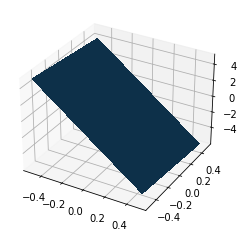

In [31]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


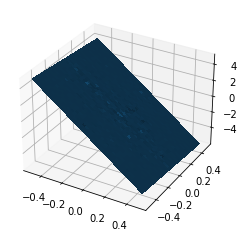

In [37]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi_noised, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [38]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.gradient(M, axis=0) / stepY
    gx = np.gradient(M, axis=1)/stepX
    
    return gx,gy

In [40]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

gx_noised, gy_noised = gradient(phi_noised,1/M,1/N)
GX_noised = np.median(gx_noised)
GY_noised = np.median(gy_noised)

In [41]:
print(GX_noised)
print(GY_noised)

-9.999922810033297
-0.9995646201959971


In [42]:
print(GX)
print(GY)

-10.0
-1.0


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

In [43]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [44]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [45]:
print(bEst)

[-9.99981832 -0.99999929]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

10.0
1.0


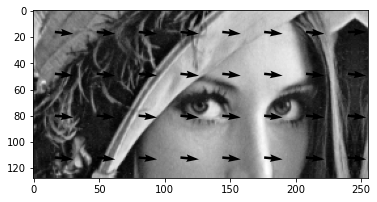

In [19]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

5.849325226370629
0.49470959851673235


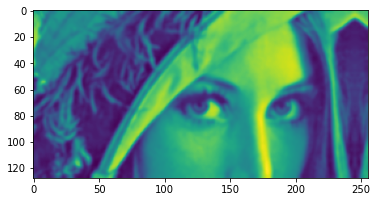

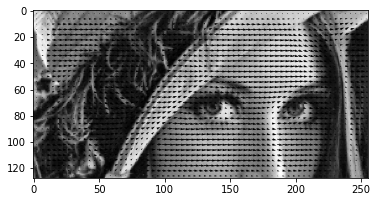

In [20]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)